## Final Project Submission

Please fill out:
* Student name: Michael Cuevas
* Student pace: self paced / part time / full time: Flex (Self Paced)
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL: https://kscuevasflatiron.blogspot.com/2023/06/ai-and-data-analysis-integration.html

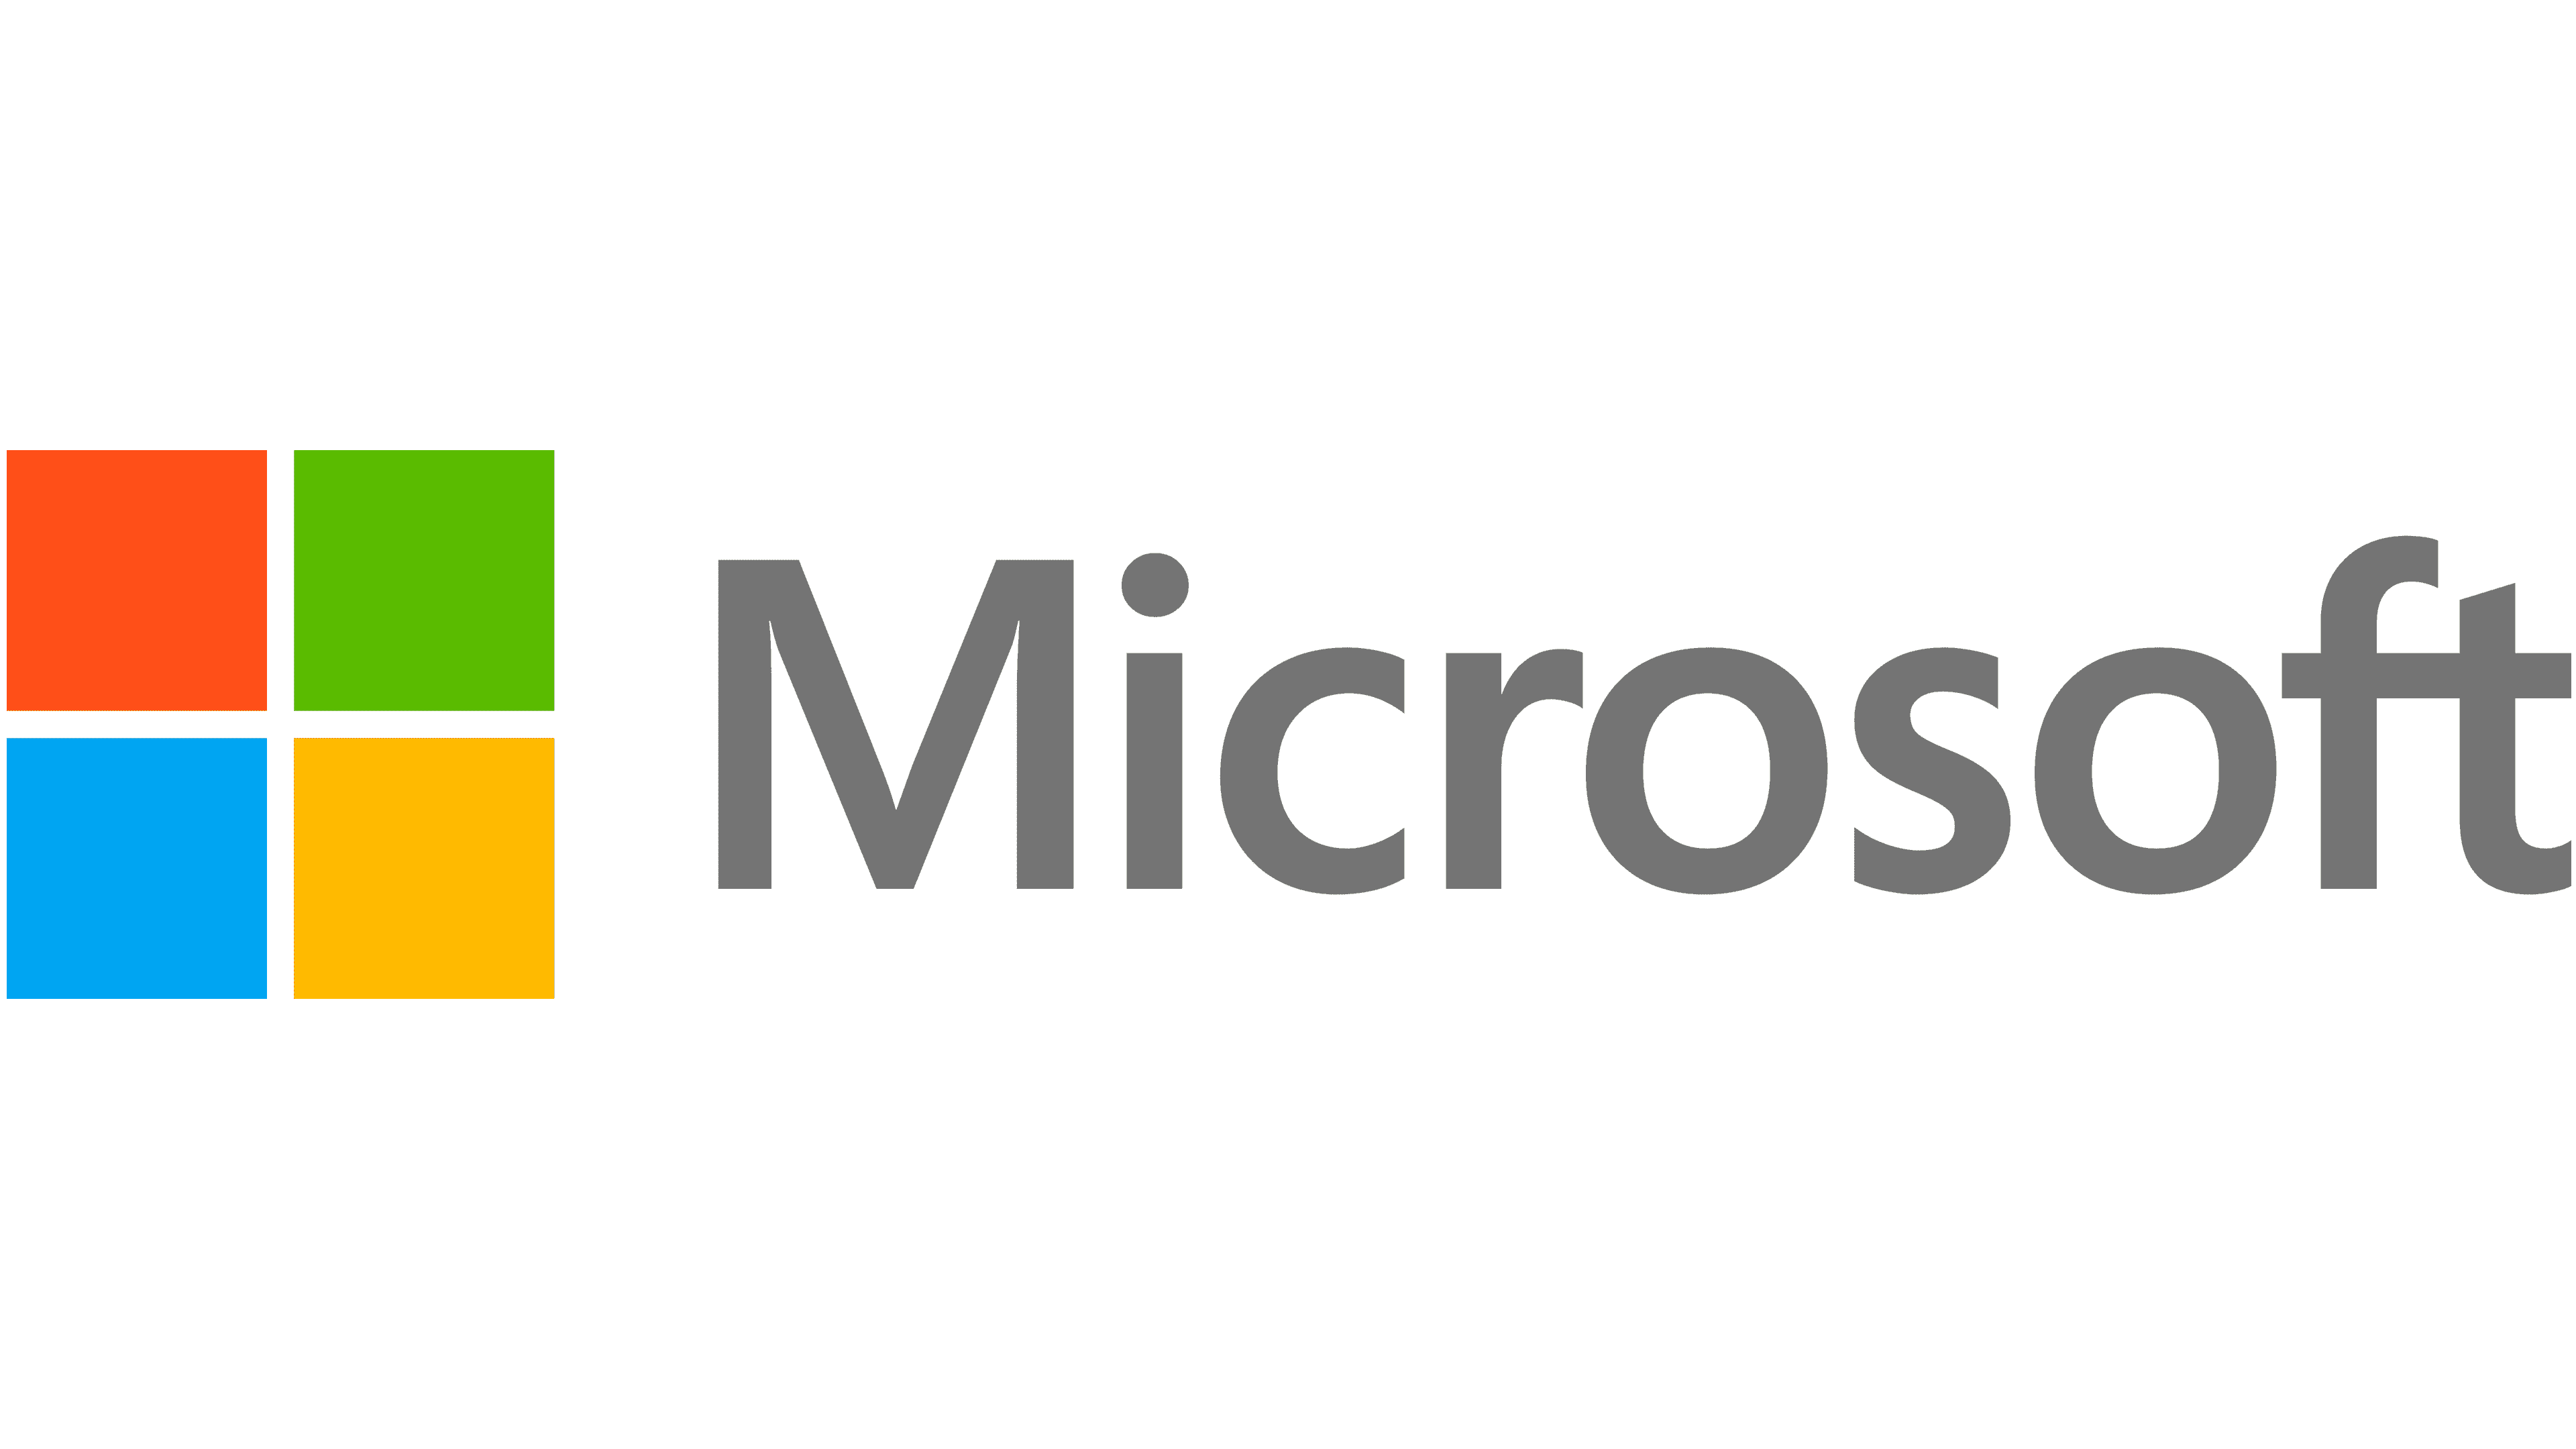

# Business Problem
 <i>Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. I am being charged with exploring what types of films are currently doing the best at the box office. I will then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.</i>

*** 
## Active Reccomendation Proposal

My primary reccomendations will be to look into a potential films grossing profit, and which factors to take into consideration to maximize those numbers:

* <b>Genre</b> : Which film genre is doing the best financially?
* <b>Runtime</b> : How long should the average run time of a movie be?
* <b>Actors</b> : What actors would be best to contract out to entice customers into buying movie tickets?


In [1]:
# importing the needed libraries
import pandas as pd 
import numpy as np
import sqlite3
import json

# importing packages for graph building and visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# Making the CSV files readable
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')

# importing the sql database and connecting to it now to save time
im_db = 'zippedData/im.db/im.db'
conn = sqlite3.connect(im_db)
cursor = conn.cursor()

***

## Data Preparation

To start, the data we have on hand is provided to us as is, and thus we can't get the information we need just yet on account that there may be missing variables, information present on one table that isnt on another, and so on. Cleaning up this information prior to making any joins, exploring and graphing the active reccomendations will be benefical.


In [2]:
# starting by looking at the tmdb_df table
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
# and then looking at the im_db database movie_basics table
pd.read_sql("""
SELECT *
FROM movie_basics
""", conn).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [4]:
# then bom_df
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Looking at the information within the <font color=blue>*bom_df file*</font>, right away we can note that there's a significantly notable amount of missing data within the <font color=blue>*foreign_gross*</font> column compared to the the <font color=blue>*studio*</font> or <font color=blue>*domestic_gross*</font> columns. Because of how much missing information there is, I'm going to be dropping it from the table since replacing those values with a 0 or even a mean value of the <font color=blue>*foreign_gross*</font> column would greatly alter the data we use.

In [5]:
#i'll also be dropping studio on top of foreign_gross
bom_df.drop(['foreign_gross','studio'], inplace=True, axis=1)
bom_df.head()

# we can also drop some of the columns in tmdb_df that we won't need here too
tmdb_df.drop(['Unnamed: 0', 'id', 'original_language', 'original_title'], inplace=True, axis=1)
tmdb_df.head()

,genre_ids,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27.920,2010-07-16,Inception,8.3,22186


***

# API Calling

Prior to any table joining thats going to happen, its important to note that unlike the <font color=blue>*im_db*</font> and <font color=blue>*bom_df*</font> tables, <font color=blue>*tmdb_df*</font> has a genre column that is listed by numerical ID as opposed to actual genre name. <a href="https://www.themoviedb.org/">The Movie Database</a> has the option to request an API key to fetch the genre names in question to match to numerical ID as seen on the table.


In [6]:
# after running the API and getting the assigned genre IDs, this dictionary will
# be used to assign the actual genre name to its respective numbered ID
assignGenre = {
    "28":"Action", "12":"Adventure", "16":"Animation", "35":"Comedy", "80":"Crime", "99":"Documentary",
    "18":"Drama", "10751":"Family", "14":"Fantasy", "36":"History", "27":"Horror", "10402":"Music",
    "9648":"Mystery", "10749":"Romance", "878":"Science Fiction", "10770":"TV Movie", "53":"Thriller",
    "10752":"War", "37":"Western", "8":"Unassigned"
            }


# in addition; since the number 8 isnt delegated to any genre, we can assign it to the table
# and use it to represent any movie that doesn't have any genre labels
tmdb_df['genre_ids'].replace(to_replace= '[]', value = '[8]', inplace = True)

# using a function we can then use the dictionary we created above and begin to assign
# number ID to its respective genre
def assign(genre_here):
    desc = ''
    for num in genre_here.strip('][').split(', '):
        desc += assignGenre[num]
        desc += ','
    return desc.rstrip(',')
# now we can run it through and begin assigning genres on the table
tmdb_df['genre_ids'] = tmdb_df['genre_ids'].map(lambda genre: assign(genre))


tmdb_df.head()

,genre_ids,popularity,release_date,title,vote_average,vote_count
0,"Adventure,Fantasy,Family",33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"Fantasy,Adventure,Animation,Family",28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"Adventure,Action,Science Fiction",28.515,2010-05-07,Iron Man 2,6.8,12368
3,"Animation,Comedy,Family",28.005,1995-11-22,Toy Story,7.9,10174
4,"Action,Science Fiction,Adventure",27.920,2010-07-16,Inception,8.3,22186


Genres have been assigned! Now that the genre tags for a movie are easier to read, we can continue on from here.

***

## Continue Cleaning...

Genres for tmdb_df have been assigned, we can continue cleaning and organizing.

In [7]:
# starting first by organizing the tmdb_df table for easier access first
# since it's the only table out of the three we're using that has a complete
# data set without missing variables
tmdb_df = tmdb_df.loc[:, ['title', 'genre_ids', 'release_date', 'popularity', 'vote_average','vote_count']]

tmdb_df.head()

,title,genre_ids,release_date,popularity,vote_average,vote_count
0,Harry Potter and the Deathly Hallows: Part 1,"Adventure,Fantasy,Family",2010-11-19,33.533,7.7,10788
1,How to Train Your Dragon,"Fantasy,Adventure,Animation,Family",2010-03-26,28.734,7.7,7610
2,Iron Man 2,"Adventure,Action,Science Fiction",2010-05-07,28.515,6.8,12368
3,Toy Story,"Animation,Comedy,Family",1995-11-22,28.005,7.9,10174
4,Inception,"Action,Science Fiction,Adventure",2010-07-16,27.920,8.3,22186


In [8]:
# I want the im_db data to have actors, genres, and movie names all in one 
# place for ease of access. In this case I will be leaving out the
# original_title column and use an alias instead

combined_imdb = pd.read_sql("""
SELECT movie_id, (primary_title) AS title, genres,
(start_year) AS year, (runtime_minutes) AS runtime_in_mins,
(averagerating) AS avg_rating, numvotes
FROM movie_basics
LEFT JOIN movie_ratings
USING (movie_id)
;
""", conn)

combined_imdb.head()

,movie_id,title,genres,year,runtime_in_mins,avg_rating,numvotes
0,tt0063540,Sunghursh,"Action,Crime,Drama",2013,175.0,7.0,77.0
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama",2019,114.0,7.2,43.0
2,tt0069049,The Other Side of the Wind,Drama,2018,122.0,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,"Comedy,Drama",2018,NaN,6.1,13.0
4,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy",2017,80.0,6.5,119.0


In [9]:
# now we go and get a list of actors and actors only in this case since this will
# be relevant for one of our proposals
actor_info = pd.read_sql("""
SELECT movie_id, (primary_name) AS actors
FROM principals
JOIN persons
USING (person_id)
WHERE category = 'actor'
ORDER BY movie_id
;
""", conn)

actor_info.head()

,movie_id,actors
0,tt0063540,Dilip Kumar
1,tt0063540,Balraj Sahni
2,tt0063540,Sanjeev Kumar
3,tt0066787,Arun Khopkar
4,tt0066787,Om Shivpuri


In [10]:
# now to combine the two lists we made`
imdb_list = pd.merge(actor_info, combined_imdb, how = 'left', on = 'movie_id')

# since we also have missing runtime_in_mins values, we can also fill those in here
# using the mode for movies missing a runtime to avoid the potential for
# outliers in our data when graphing our runtime average reccomendation
imdb_list['runtime_in_mins'].fillna(imdb_list['runtime_in_mins'].mode(), inplace = True)

#we should also rearrange the column organization for the future too
imdb_list = imdb_list.loc[:, ['movie_id','title', 'genres',
                              'actors', 'year','runtime_in_mins',
                              'avg_rating', 'numvotes']]

imdb_list.head()

,movie_id,title,genres,actors,year,runtime_in_mins,avg_rating,numvotes
0,tt0063540,Sunghursh,"Action,Crime,Drama",Dilip Kumar,2013,175.0,7.0,77.0
1,tt0063540,Sunghursh,"Action,Crime,Drama",Balraj Sahni,2013,175.0,7.0,77.0
2,tt0063540,Sunghursh,"Action,Crime,Drama",Sanjeev Kumar,2013,175.0,7.0,77.0
3,tt0066787,One Day Before the Rainy Season,"Biography,Drama",Arun Khopkar,2019,114.0,7.2,43.0
4,tt0066787,One Day Before the Rainy Season,"Biography,Drama",Om Shivpuri,2019,114.0,7.2,43.0


From here, we can start to combine <font color=blue>*imdb_list*</font> with our <font color=blue>*bom_df*</font> data first before combining with <font color=blue>*tmdb_df*</font>.

In [11]:
# combining imdb_list and bom_df first
imdb_bom = pd.merge(imdb_list, bom_df, how = 'outer', on = 'title')

# we're going to have duplicate years, so we can create a new column to combine...
imdb_bom['year'] = imdb_bom['year_x'].fillna(imdb_bom['year_y'])

# and then drop
imdb_bom.drop(['year_x','year_y', 'movie_id'], inplace=True, axis=1)

imdb_bom

,title,genres,actors,runtime_in_mins,avg_rating,numvotes,domestic_gross,year
0,Sunghursh,"Action,Crime,Drama",Dilip Kumar,175.0,7.0,77.0,NaN,2013.0
1,Sunghursh,"Action,Crime,Drama",Balraj Sahni,175.0,7.0,77.0,NaN,2013.0
2,Sunghursh,"Action,Crime,Drama",Sanjeev Kumar,175.0,7.0,77.0,NaN,2013.0
3,One Day Before the Rainy Season,"Biography,Drama",Arun Khopkar,114.0,7.2,43.0,NaN,2019.0
4,One Day Before the Rainy Season,"Biography,Drama",Om Shivpuri,114.0,7.2,43.0,NaN,2019.0
...,...,...,...,...,...,...,...,...
257510,Hannah (2018),NaN,NaN,NaN,NaN,NaN,11700.0,2018.0
257511,Furious (Legend of Kolovrat),NaN,NaN,NaN,NaN,NaN,10000.0,2018.0
257512,Edward II (2018 re-release),NaN,NaN,NaN,NaN,NaN,4800.0,2018.0
257513,El Pacto,NaN,NaN,NaN,NaN,NaN,2500.0,2018.0


In [12]:
#and then combine the newly created imdb_bom wih tmdb_df
proto_table = pd.merge(imdb_bom, tmdb_df, how = 'outer', on ='title')

proto_table.head()

,title,genres,actors,runtime_in_mins,avg_rating,numvotes,domestic_gross,year,genre_ids,release_date,popularity,vote_average,vote_count
0,Sunghursh,"Action,Crime,Drama",Dilip Kumar,175.0,7.0,77.0,NaN,2013.0,NaN,NaN,NaN,NaN,NaN
1,Sunghursh,"Action,Crime,Drama",Balraj Sahni,175.0,7.0,77.0,NaN,2013.0,NaN,NaN,NaN,NaN,NaN
2,Sunghursh,"Action,Crime,Drama",Sanjeev Kumar,175.0,7.0,77.0,NaN,2013.0,NaN,NaN,NaN,NaN,NaN
3,One Day Before the Rainy Season,"Biography,Drama",Arun Khopkar,114.0,7.2,43.0,NaN,2019.0,NaN,NaN,NaN,NaN,NaN
4,One Day Before the Rainy Season,"Biography,Drama",Om Shivpuri,114.0,7.2,43.0,NaN,2019.0,NaN,NaN,NaN,NaN,NaN


We have everything in one place, now we can begin combining and cleaning up any remaining data for a final table.

In [13]:
# filling in missing information for genres, year, avg_rating and numvotes with information from
# genre_ids, release_date, vote_average and vote_count
proto_table['genres'] = proto_table['genres'].fillna(proto_table['genre_ids'])
proto_table['avg_rating'] = proto_table['avg_rating'].fillna(proto_table['vote_average'])
proto_table['numvotes'] = proto_table['numvotes'].fillna(proto_table['vote_count'])


# we want to convert the year column into date time here as to only display the year for each movie
# this will keep the year column as the year and year only, as opposed to year/1/1 for each row
proto_table['year'] = pd.to_datetime(proto_table['year'], format='%Y').fillna(proto_table['release_date'])
proto_table['year'] = pd.DatetimeIndex(proto_table['year']).year

# we still have some missing information that we can fill in here as well
proto_table['domestic_gross'].fillna(proto_table['domestic_gross'].median(), inplace = True)
proto_table['popularity'].fillna(proto_table['popularity'].median(), inplace = True)
proto_table['runtime_in_mins'].fillna(proto_table['runtime_in_mins'].median(), inplace = True)

# since we filled in information from our duplicate tables, we can drop the ones we used
proto_table.drop(['genre_ids', 'release_date', 'vote_average', 'vote_count', 'popularity'], axis=1, inplace = True)
# and then drop duplicates in the table
proto_table.drop_duplicates(subset=None, keep="first", inplace=True)


# then sort by domestic gross
proto_table = proto_table.sort_values('domestic_gross', ascending=False)

proto_table

,title,genres,actors,runtime_in_mins,avg_rating,numvotes,domestic_gross,year
265663,Star Wars: The Force Awakens,"Action,Adventure,Science Fiction,Fantasy",NaN,90.0,7.4,12641.0,936700000.0,2015
45595,Black Panther,"Action,Adventure,Sci-Fi",Michael B. Jordan,134.0,7.3,516148.0,700100000.0,2018
45593,Black Panther,"Action,Adventure,Sci-Fi",Chadwick Boseman,134.0,7.3,516148.0,700100000.0,2018
150635,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Chris Hemsworth,149.0,8.5,670926.0,678800000.0,2018
150634,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Robert Downey Jr.,149.0,8.5,670926.0,678800000.0,2018
...,...,...,...,...,...,...,...,...
168030,Satanic,Horror,Justin Chon,85.0,3.7,5381.0,300.0,2016
265797,The Chambermaid,NaN,NaN,90.0,NaN,NaN,300.0,2015
265909,News From Planet Mars,NaN,NaN,90.0,NaN,NaN,300.0,2016
57962,Storage 24,"Action,Horror,Mystery",Noel Clarke,87.0,4.4,6229.0,100.0,2012


It looks like there's missing information towards the end of the table with the exception of <font color=blue>*title*</font>, <font color=blue>*domestic_gross*</font>, <font color=blue>*year*</font> and <font color=blue>*popularity*</font>. Since we're looking at <font color=blue>*genres*</font>, <font color=blue>*actors*</font>, and <font color=blue>*runtime*</font> for our reccomendations, we can do away with any movies that dont meet these criterias.


In [14]:
# removing movies that have less than 500 votes total and less than a 60 min runtime
final_table = proto_table[proto_table['numvotes'] > 500]
final_table = proto_table[proto_table['runtime_in_mins'] > 60]

# dropping rows that may still contain any NaN statements somewhere
final_table = final_table.dropna()

final_table

,title,genres,actors,runtime_in_mins,avg_rating,numvotes,domestic_gross,year
45595,Black Panther,"Action,Adventure,Sci-Fi",Michael B. Jordan,134.0,7.3,516148.0,700100000.0,2018
45593,Black Panther,"Action,Adventure,Sci-Fi",Chadwick Boseman,134.0,7.3,516148.0,700100000.0,2018
150635,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Chris Hemsworth,149.0,8.5,670926.0,678800000.0,2018
150634,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Robert Downey Jr.,149.0,8.5,670926.0,678800000.0,2018
150637,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Chris Evans,149.0,8.5,670926.0,678800000.0,2018
...,...,...,...,...,...,...,...,...
11209,2:22,Thriller,Michiel Huisman,98.0,5.8,16318.0,400.0,2017
168029,Satanic,Horror,Steven Krueger,85.0,3.7,5381.0,300.0,2016
168030,Satanic,Horror,Justin Chon,85.0,3.7,5381.0,300.0,2016
57962,Storage 24,"Action,Horror,Mystery",Noel Clarke,87.0,4.4,6229.0,100.0,2012


***

## Proposal One: Genre Success

*___Which film genre is doing the best financially?___*

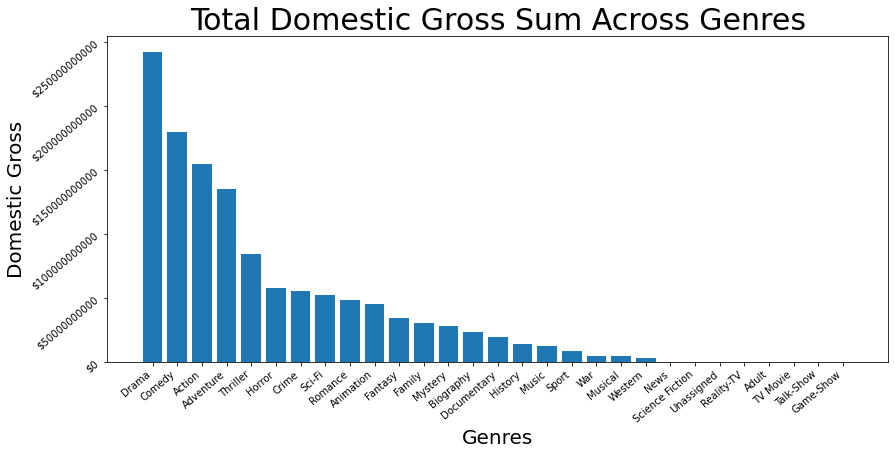

In [15]:
# since there's movies in our dataset that may have more than one genre attatched to its
# name, we'll make a separate and compiled list of all the genres that are available for us to look at
genreGrouping = []
for genrelist in final_table['genres']:
    for item in genrelist.split(','):
        genreGrouping.append(item)   

# this will make sure we get a list of each unique genre present in the dataset and avoid duplicates
allGenres = set(genreGrouping)


# from here, we can use the genre list we just made and use a for loop to calculate the 
# collective total amount each genre type has made
sumGross = {}   
for genre in allGenres:
    total = final_table[final_table['genres'].str.contains(genre)]['domestic_gross'].sum()
    sumGross[genre] = total
    
# we can now place our information on the respective axis we want it correlated on 
# and tell it to ascend from greatest to least
totalGenres = sorted(sumGross, key=sumGross.get, reverse = True)
totalGross = sorted(sumGross.values(), reverse = True)

# now to graph our information
fig, ax= plt.subplots(figsize=(14,6))
ax.bar(totalGenres, totalGross)

# this will set our y-axis ticks to display in $, or USD in this case. we'll be using it
# for our other graphs as well
ax.yaxis.set_major_formatter('${x:1.0f}')

plt.yticks(rotation=40, ha='right')
ax.set_xlabel('Genres', fontsize=20)
ax.set_ylabel('Domestic Gross', fontsize=20)
ax.set_title('Total Domestic Gross Sum Across Genres', fontsize=30)
plt.xticks(rotation=40, ha='right')

plt.show();

Looking at the graph, it seems the best or top selling genre of movie to produce would be one that falls in the Drama genre. Some runner-ups genres to also consider for movie production would also be the Comedy, Action and Adventure genres as well. Or, possibly a combination of the top 4 most successful genres as seen above in possible multiple combinations for a future film.

***

## Proposal Two: Runtime Average

*___What's the best film runtime goal to aim for?___*


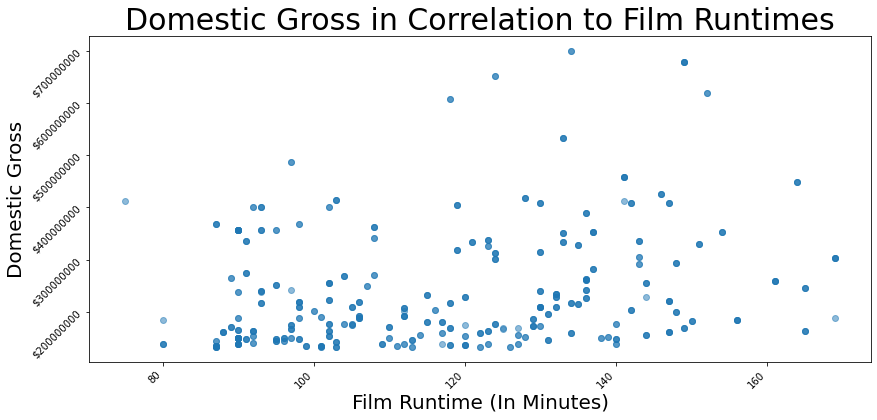

In [16]:
fig, ax= plt.subplots(figsize=(14,6))

domGrossing = final_table['domestic_gross'].head(500)
timeAvg = final_table['runtime_in_mins'].head(500)

ax.scatter(timeAvg, domGrossing, alpha = 0.5)

ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlabel('Film Runtime (In Minutes)', fontsize=20)
ax.set_ylabel('Domestic Gross', fontsize=20)
ax.set_title('Domestic Gross in Correlation to Film Runtimes', fontsize=30)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.show();

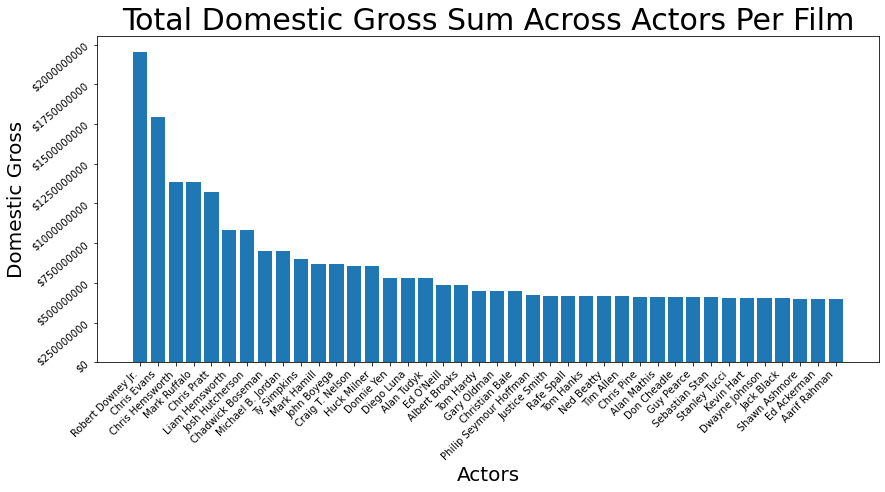

In [17]:
# we'll want the top 4 actors for this segement, so i'm going to reduce this table to only 50 rows.
actor_graphing = final_table.head(50)

# since there's movies in our dataset that may have more than one actor attatched to its
# name, we'll make a separate and compiled list of all the actors that are available for us to look at
actorGrouping = []
for actlist in actor_graphing['actors']:
    for item in actlist.split(','):
        actorGrouping.append(item)
        

# this will make sure we get a list of each unique actor present in the dataset and avoid duplicates
allActors = set(actorGrouping)


# from here, we can use the actor list we just made and use a for loop to calculate the 
# collective total amount each actor type has made
actor_sumGross = {}   
for actor in allActors:
    total = actor_graphing[actor_graphing['actors'].str.contains(actor)]['domestic_gross'].sum()
    actor_sumGross[actor] = total

    
# we can now place our information on the respective axis we want it correlated on 
# and tell it to ascend from greatest to least
totalActors = sorted(actor_sumGross, key=actor_sumGross.get, reverse = True)
actorTotalGross = sorted(actor_sumGross.values(), reverse = True)

# now to graph our information
fig, ax= plt.subplots(figsize=(14,6))
ax.bar(totalActors, actorTotalGross)

# this will set our y-axis ticks to display in $, or USD in this case. we'll be using it
# for our other graphs as well
ax.yaxis.set_major_formatter('${x:1.0f}')

plt.yticks(rotation=40, ha='right')
ax.set_xlabel('Actors', fontsize=20)
ax.set_ylabel('Domestic Gross', fontsize=20)
ax.set_title('Total Domestic Gross Sum Across Actors Per Film', fontsize=30)
plt.xticks(rotation=45, ha='right')

plt.show();

In regards to potential and suitable actors, Robert Downey Jr seems to be the best candidate to choose when it comes to picking an actor to get the public's interests. Some other possible actors to consider contracting would also include: Chris Evans, Chris Hemsworth, Mark Ruffalo and Chris Pratt.

***
# Conclusions:

Our analysis results now give a better insight as to where Microsoft's new film production should focus their resources into: 

* **Genre:** Our top grossing genre results show us that the best ones to take advantage of are the Drama, Comedy, Adventure and Animation genres.


* **Runtime Average:** The best average runtime to aim for when it comes to any upcoming films should be between 120 and 140 minutes. Or, an overall runtime average of 130 minutes.


* **Actors to Consider:** To get the mass public's eyes, it would be ideal to contract out Robert Downey Jr., Chris Evans, Chris Hemsworth and Mark Ruffalo.


## Next Steps to Consider:

* **Directors:** On top of finding the best actors, it would also be good to find some of the best directors as well to bring onboard for any future film projects.


* **Budgeting:** Find and make an appropriate budget to take into consideration for filming so that the costs to produce doesn't outweigh the domestic gross returned once a film is released to the public for viewing.


* **Standalones or Sequels:** Decide if a film would be best as a standalone or as a series with either sequels or as a potential trilogy.
